In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('/content/BTC.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].replace({',':''},regex=True).apply(pd.to_numeric)
df = df[['Date','Price']]
df = df.set_index('Date')
df.head()

,Price
Date,
2021-05-19,38678.4
2021-05-18,42897.3
2021-05-17,43541.3
2021-05-16,46426.4
2021-05-15,46708.8


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,3959.0,4628.089972,9637.641401,0.1,79.45,573.9,6643.1,63540.9


### Split the Data

In [4]:
column_indices = {name:i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [5]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean ) / train_std

### Data Windowing

In [22]:
class WindowGenerator:
  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_column_indices = {name: i for i,name in enumerate(label_columns)}
    self.column_indices = {name: i for i,name in enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift
    
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


In [23]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Price'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Price']

In [24]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Price'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Price']

In [25]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
labels shape: (3, 1, 1)


### Plot

In [26]:
w2.example = example_inputs, example_labels

In [32]:
def plot(self, model=None, plot_col='Price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_column_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

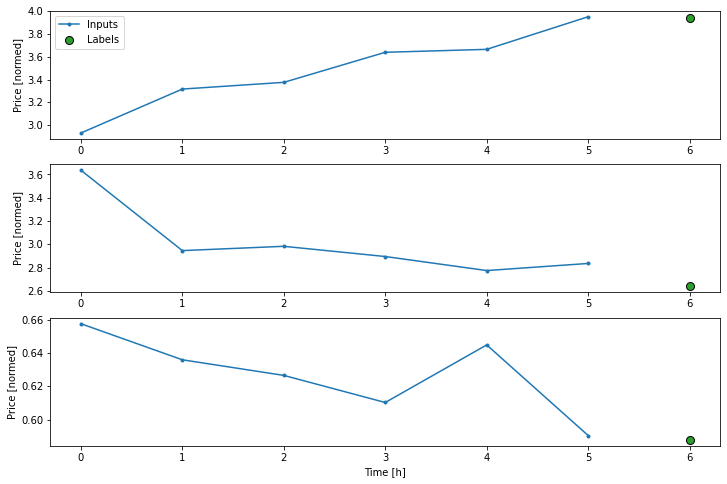

In [33]:
w2.plot()

### Create tf.data.Datasets

In [38]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length = self.total_window_size,
      sequence_stride = 1,
      shuffle=True,
      batch_size=32
  )

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [39]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train))
    self._example = result

  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [40]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [41]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


### Single Step models

In [43]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Price']
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Price']

In [44]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

In [47]:
class Baseline(tf.keras.Model):

  def __init__(self,label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:,:,self.label_index]
    return result[:,:,tf.newaxis]

In [49]:
baseline = Baseline(label_index=column_indices['Price'])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

25/25 [==============================] - 0s 3ms/step - loss: 1.4861e-07 - mean_absolute_error: 1.3873e-04


In [58]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['Price']
)

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Price']

In [59]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 30, 1)


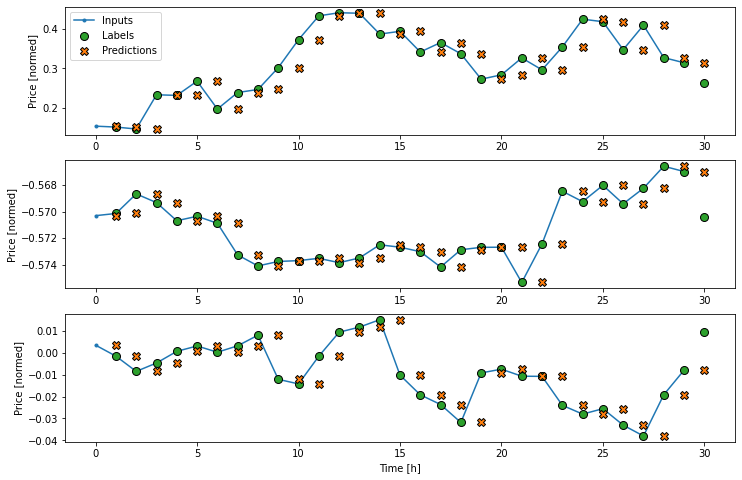

In [60]:
wide_window.plot(baseline)

### Linear model

In [68]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [69]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [70]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [71]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
87/87 [==============================] - 1s 5ms/step - loss: 1.9203 - mean_absolute_error: 0.8311 - val_loss: 0.7002 - val_mean_absolute_error: 0.8368
Epoch 2/20
87/87 [==============================] - 0s 4ms/step - loss: 1.7729 - mean_absolute_error: 0.7956 - val_loss: 0.6315 - val_mean_absolute_error: 0.7947
Epoch 3/20
87/87 [==============================] - 0s 4ms/step - loss: 1.5358 - mean_absolute_error: 0.7461 - val_loss: 0.5690 - val_mean_absolute_error: 0.7543
Epoch 4/20
87/87 [==============================] - 0s 4ms/step - loss: 1.4409 - mean_absolute_error: 0.7156 - val_loss: 0.5089 - val_mean_absolute_error: 0.7134
Epoch 5/20
87/87 [==============================] - 0s 5ms/step - loss: 1.2615 - mean_absolute_error: 0.6785 - val_loss: 0.4538 - val_mean_absolute_error: 0.6736
Epoch 6/20
87/87 [==============================] - 0s 4ms/step - loss: 1.1610 - mean_absolute_error: 0.6461 - val_loss: 0.4066 - val_mean_absolute_error: 0.6376
Epoch 7/20
87/87 [==========

In [72]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 30, 1)


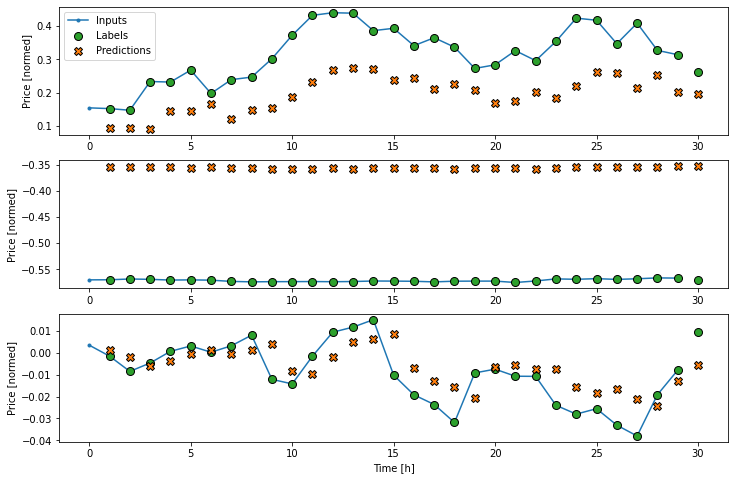

In [73]:
wide_window.plot(linear)

### Dense

In [76]:
dense = tf.keras.Sequential([
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dense(1),
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
87/87 [==============================] - 1s 6ms/step - loss: 0.4026 - mean_absolute_error: 0.2981 - val_loss: 2.5061e-04 - val_mean_absolute_error: 0.0158
Epoch 2/20
87/87 [==============================] - 0s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0287 - val_loss: 1.0717e-04 - val_mean_absolute_error: 0.0103
Epoch 3/20
87/87 [==============================] - 0s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0219 - val_loss: 1.3053e-05 - val_mean_absolute_error: 0.0036
Epoch 4/20
87/87 [==============================] - 0s 5ms/step - loss: 0.0026 - mean_absolute_error: 0.0204 - val_loss: 9.2892e-05 - val_mean_absolute_error: 0.0096
Epoch 5/20
25/25 [==============================] - 0s 3ms/step - loss: 9.0639e-05 - mean_absolute_error: 0.0095


In [78]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Price']
)
conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Price']

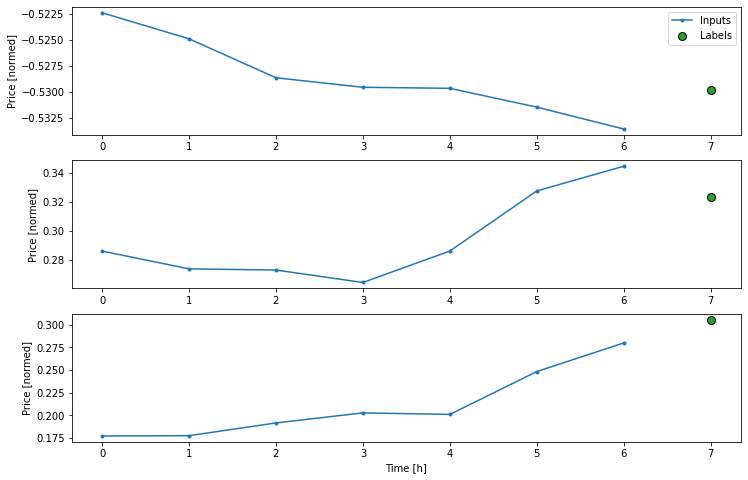

In [79]:
conv_window.plot()

In [80]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1,-1])
])

In [81]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 7, 1)
Output shape: (32, 1, 1)


In [82]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
87/87 [==============================] - 1s 5ms/step - loss: 1.0071 - mean_absolute_error: 0.3201 - val_loss: 7.7815e-06 - val_mean_absolute_error: 0.0027
Epoch 2/20
87/87 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_absolute_error: 0.0455 - val_loss: 1.0690e-05 - val_mean_absolute_error: 0.0032
Epoch 3/20
87/87 [==============================] - 0s 5ms/step - loss: 0.0069 - mean_absolute_error: 0.0326 - val_loss: 4.4161e-06 - val_mean_absolute_error: 0.0021
Epoch 4/20
87/87 [==============================] - 0s 4ms/step - loss: 0.0043 - mean_absolute_error: 0.0258 - val_loss: 4.2757e-06 - val_mean_absolute_error: 0.0020
Epoch 5/20
87/87 [==============================] - 0s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0251 - val_loss: 9.2011e-07 - val_mean_absolute_error: 8.6316e-04
Epoch 6/20
87/87 [==============================] - 0s 5ms/step - loss: 0.0034 - mean_absolute_error: 0.0233 - val_loss: 2.9623e-06 - val_mean_absolute_error: 0.0017


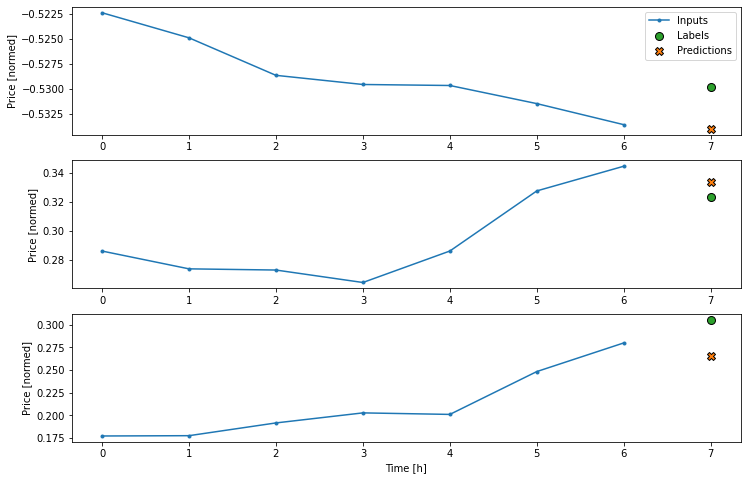

In [83]:
conv_window.plot(multi_step_dense)

### Convolution neural network

In [91]:
conv_model = tf.keras.Sequential([
     tf.keras.layers.Conv1D(32,kernel_size=(CONV_WIDTH,),
                            activation='relu'),
     tf.keras.layers.Dense(32, activation='relu'),
     tf.keras.layers.Dense(1)                             
])

In [92]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 7, 1)
Output shape: (32, 1, 1)


In [93]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

25/25 [==============================] - 0s 3ms/step - loss: 5.6298e-05 - mean_absolute_error: 0.0075


In [94]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 30, 1)
Labels shape: (32, 30, 1)
Output shape: (32, 24, 1)


In [95]:
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Price']
)

wide_conv_window

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36]
Label column name(s): ['Price']

In [96]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 36, 1)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


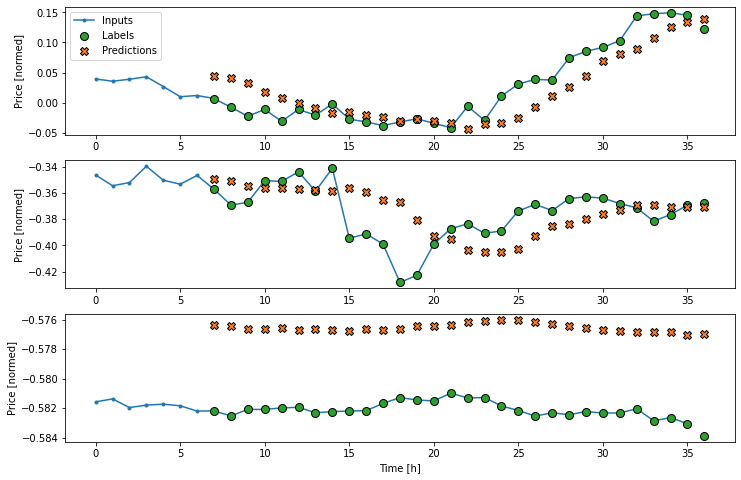

In [98]:
wide_conv_window.plot(conv_model)

### Recurrent Neural Network

In [99]:
lstm_model = tf.keras.models.Sequential([
     tf.keras.layers.LSTM(32,return_sequences=True),
     tf.keras.layers.Dense(1)                                    
])

In [100]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 1)
Output shape: (32, 30, 1)


In [101]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

24/24 [==============================] - 0s 5ms/step - loss: 8.6299e-04 - mean_absolute_error: 0.0108


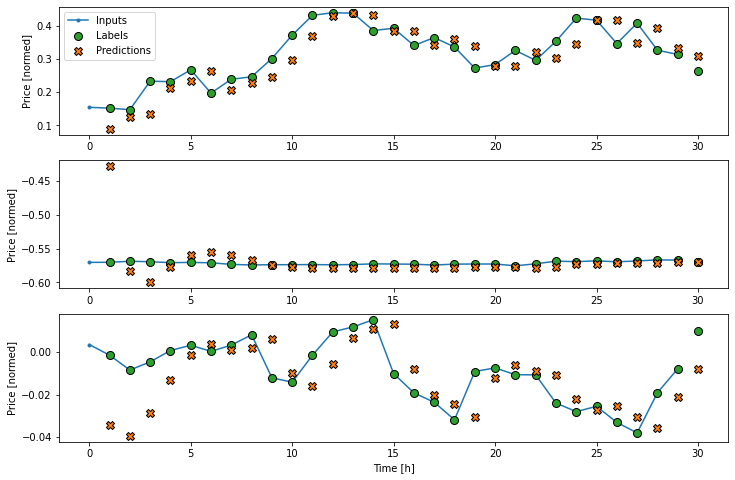

In [102]:
wide_window.plot(lstm_model)